This notebook descrbies the PORT-EK pipeline analysis of k-mers genreated from the "bat" dataset from [reference to our paper].
To use it you will need the k-mer indices generated with PORTEKfind.py in the output/bat/15mer_indices directory.
To generate the indices as in the paper, you will need to run PORTEKfind.py on the appropriate data sets, previously downloaded in fasta files, using the following commands from the main PORT-EK directory:
 - python PORTEKfind.py input/bat/bat.fasta output/bat/[k]mer_indices/ --k [k] --group bat
 - python PORTEKfind.py input/bat/EPI_SET_240422qm.fasta output/bat/[k]mer_indices/ --k [k] --group hum

For the selection of optimal k please see optimal_bat_k_selection.ipynb notebook. 

1. Import necessary libraries and PORT-EK source code:

In [1]:
import sys
import json
import pathlib
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import SeqIO

# adding portek source directory to sys path before importing
portek_path = "../portek"
sys.path.insert(0, portek_path)
import portek

pd.options.mode.copy_on_write = True

2. Declare data set specific definitions and functions:

In [2]:
# PORT-EK parameters
c = 0.5  # This is the conservation thershold used in k-mer rarity filter.
m = 2  # This is the maximum number of mismatches allowed when re-examining rare k-mers.
min_RMSE = 0.1  # This is the RMSE threshold used to select enriched k-mers.
m_map = 2  # This is the maximum number of mismatches allowed when mapping k-mers to reference genome.
l_map = 1000  # This the maximum allowed offset of mapping position from average position of k-mer in samples.

# Relative path to k-mer indices.
INPUT_PATH = "../output/bat/15mer_indices"

# Data set specific definitions of k-mer type, column names, reference gene and protein mapping, and colors for plots.

FREQ_COLS = ["bat_freq", "hum_freq"]
AVG_COLS = [
    "bat_avg",
    "hum_avg",
]
VOLCANO_CMAP = {
    "not significant": ("#DDDDDD", 0.5),
    "bat over-represented": ("#870f7e", 1),
    "human over-represented": ("#005ff5", 1),
}
GENE_ORDER_LIST = [
    "orf1ab",
    "S",
    "orf3a",
    "E",
    "M",
    "orf6",
    "orf7a",
    "orf7b",
    "orf8",
    "N",
    "orf10",
    "intergenic",
]
PROTEIN_ORDER_LIST = [
    "nsp1",
    "nsp2",
    "nsp3",
    "nsp4",
    "nsp5",
    "nsp6",
    "nsp7",
    "nsp8",
    "nsp9",
    "nsp10",
    "nsp12",
    "nsp13",
    "nsp14",
    "nsp15",
    "nsp16",
    "S",
    "orf3a",
    "E",
    "M",
    "orf6",
    "orf7a",
    "orf7b",
    "orf8",
    "N",
    "orf10",
    "non-coding",
]


def assign_kmer_type(row):
    if row["bat_err"] > 0 and row["p-value"] < 0.01:
        return "bat over-represented"
    elif row["bat_err"] < 0 and row["p-value"] < 0.01:
        return "human over-represented"
    else:
        return "not significant"


def assign_gene(pos):
    if pos in range(266, 21555 + 1):
        gene = "orf1ab"
    elif pos in range(21563, 25384 + 1):
        gene = "S"
    elif pos in range(25393, 26220 + 1):
        gene = "orf3a"
    elif pos in range(26245, 26472 + 1):
        gene = "E"
    elif pos in range(26523, 27191 + 1):
        gene = "M"
    elif pos in range(27202, 27387 + 1):
        gene = "orf6"
    elif pos in range(27394, 27759 + 1):
        gene = "orf7a"
    elif pos in range(27756, 27887 + 1):
        gene = "orf7b"
    elif pos in range(27894, 28259 + 1):
        gene = "orf8"
    elif pos in range(28274, 29533 + 1):
        gene = "N"
    elif pos in range(29558, 29674 + 1):
        gene = "orf10"
    else:
        gene = "intergenic"
    return gene


def assign_protein(pos):
    if pos in range(266, 805 + 1):
        protein = "nsp1"
    elif pos in range(806, 2719 + 1):
        protein = "nsp2"
    elif pos in range(2720, 8554 + 1):
        protein = "nsp3"
    elif pos in range(8555, 10054 + 1):
        protein = "nsp4"
    elif pos in range(10055, 10972 + 1):
        protein = "nsp5"
    elif pos in range(10973, 11842 + 1):
        protein = "nsp6"
    elif pos in range(11843, 12091 + 1):
        protein = "nsp7"
    elif pos in range(12092, 12685 + 1):
        protein = "nsp8"
    elif pos in range(12686, 13024 + 1):
        protein = "nsp9"
    elif pos in range(13025, 13441 + 1):
        protein = "nsp10"
    elif pos in range(13442, 16236 + 1):
        protein = "nsp12"
    elif pos in range(16237, 18039 + 1):
        protein = "nsp13"
    elif pos in range(18040, 19620 + 1):
        protein = "nsp14"
    elif pos in range(19621, 20658 + 1):
        protein = "nsp15"
    elif pos in range(20659, 21555 + 1):
        protein = "nsp16"
    elif pos in range(21563, 25384 + 1):
        protein = "S"
    elif pos in range(25393, 26220 + 1):
        protein = "orf3a"
    elif pos in range(26245, 26472 + 1):
        protein = "E"
    elif pos in range(26523, 27191 + 1):
        protein = "M"
    elif pos in range(27202, 27387 + 1):
        protein = "orf6"
    elif pos in range(27394, 27759 + 1):
        protein = "orf7a"
    elif pos in range(27756, 27887 + 1):
        protein = "orf7b"
    elif pos in range(27894, 28259 + 1):
        protein = "orf8"
    elif pos in range(28274, 29533 + 1):
        protein = "N"
    elif pos in range(29558, 29674 + 1):
        protein = "orf10"
    else:
        protein = "non-coding"
    return protein

3. Construct k-mer count matrix and apply rarity filter

In [3]:
# First read all sample labels and k-mer sequences and construct an empty matrix. It requires significantly less memory than updating the table one-by-one.
kmer_set = set()
sample_list = []
in_path = pathlib.Path(INPUT_PATH).glob("**/*")

for filename in in_path:
    sample_list.append(filename.stem)
    with open(filename, mode="r") as in_file:
        temp_dict = json.load(in_file)
    kmer_set.update(temp_dict.keys())

all_kmer_matrix = pd.DataFrame(
    0, index=list(kmer_set), columns=sample_list, dtype="uint8"
)
bat_sample_idx = [sample for sample in all_kmer_matrix.columns if "bat" in sample]
hum_sample_idx = [sample for sample in all_kmer_matrix.columns if "hum" in sample]

print(f"\nImported {len(kmer_set)} kmers and {len(sample_list)} samples.")

# Next, fill the table with k-mer counts.
counter = 1
tot_files = len(sample_list)
in_path = pathlib.Path(INPUT_PATH).glob("**/*")

for filename in in_path:
    with open(filename, mode="r") as in_file:
        temp_dict = json.load(in_file)
    count_dict = {f"{filename.stem}": [len(pos) for pos in temp_dict.values()]}
    temp_df = pd.DataFrame(count_dict, index=temp_dict.keys(), dtype="uint8")
    all_kmer_matrix.update(temp_df)
    print(
        f"Completed {filename.stem}. {counter} of {tot_files} indices done.",
        end="\r",
        flush=True,
    )
    counter += 1

# Construct a temporary binary count matrix, i.e. one that shows if a k-mer is present in sequence, without regards to actual count.
# Calculate k-mer frequencies and average counts in host groups.
bin_kmer_matrix = all_kmer_matrix > 0
all_kmer_matrix["bat_freq"] = bin_kmer_matrix.loc[:, bat_sample_idx].mean(axis=1)
all_kmer_matrix["hum_freq"] = bin_kmer_matrix.loc[:, hum_sample_idx].mean(axis=1)
all_kmer_matrix["bat_avg"] = all_kmer_matrix.loc[:, bat_sample_idx].mean(axis=1)
all_kmer_matrix["hum_avg"] = all_kmer_matrix.loc[:, hum_sample_idx].mean(axis=1)
del bin_kmer_matrix

# Remove polyA, as it's presence and count is mostly dependant on sequencing quality not viral variant.
if "AAAAAAAAAAAAAAA" in all_kmer_matrix.index:
    all_kmer_matrix = all_kmer_matrix.drop("AAAAAAAAAAAAAAA")

# Apply rarity filter.
common_kmer_matrix = portek.filter_kmers(
    all_kmer_matrix, freq_cols=FREQ_COLS, cons_thr=c
)

print(
    f"\n{len(common_kmer_matrix)} common k-mers remaining after filtering at a threshold of {c}."
)


Imported 1442011 kmers and 2344 samples.
Completed hum_EPI_ISL_402128. 2344 of 2344 indices done...
32566 common k-mers remaining after filtering at a threshold of 0.5.


4. Calculate common k-mer statistics and identify host over-represented k-mers.

In [4]:
# Calculate mean k-mer count change, RMSE and test statistical significance.
common_kmer_matrix["bat_err"] = (
    common_kmer_matrix["bat_avg"] - common_kmer_matrix["hum_avg"]
)
common_kmer_matrix["bat_RMSE"] = np.sqrt((common_kmer_matrix["bat_err"] ** 2) / 2)
common_kmer_matrix["seq"] = common_kmer_matrix.index
common_kmer_matrix["p-value"] = common_kmer_matrix["seq"].apply(
    portek.calc_kmer_pvalue, args=(bat_sample_idx, hum_sample_idx, common_kmer_matrix)
)
common_kmer_matrix = common_kmer_matrix.sort_values("bat_RMSE", ascending=False)
common_kmer_matrix = common_kmer_matrix.drop("seq", axis=1)
common_kmer_matrix["-log10_p-value"] = -np.log10(common_kmer_matrix["p-value"])

# Identify host-overrepresented k-mers, according to the statistics calculated above.
common_kmer_matrix["group"] = common_kmer_matrix.apply(assign_kmer_type, axis=1)

# Make a separate DataFrame with just the statistics, without counts, for export and analysis.
common_kmer_stat_matrix = common_kmer_matrix.drop(sample_list, axis=1)

# Record over-represented k-mers in separate DataFrames
bat_overrep = common_kmer_matrix[common_kmer_matrix["group"] == "bat over-represented"]
human_overrep = common_kmer_matrix[
    common_kmer_matrix["group"] == "human over-represented"
]

print(
    f"{len(bat_overrep)} bat over-represented k-mers and {len(human_overrep)} human over-represented k-mers found."
)

/home/labadmin/repos/PORT-EK/env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


2744 bat over-represented k-mers and 29822 human over-represented k-mers found.


Optional: save/load k-mer count and statistics matrices. Uncomment the relevant lines to save/load particular files.

In [5]:
# common_kmer_matrix.to_csv("../output/bat/common_15mer_count_matrix.csv")
# common_kmer_stat_matrix.to_csv("../output/bat/common_15mer_stat_matrix.csv")
# all_kmer_matrix.to_csv("../output/bat/all_15mer_count_matrix.csv")

# common_kmer_matrix = pd.read_csv('../output/bat/common_15mer_count_matrix.csv', index_col=0)
# all_kmer_matrix = pd.read_csv('../output/bat/all_15mer_count_matrix.csv', index_col=0)
# common_kmer_stat_matrix = pd.read_csv("../output/bat/common_15mer_stat_matrix.csv", index_col=0)

5. Visualize common k-mers using volcano plots. Uncomment the last line in each cell to save as svg.

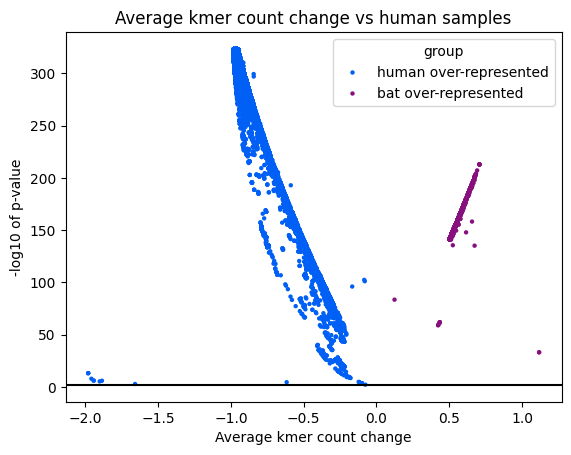

In [6]:
fig, ax = plt.subplots()
plt.axhline(y=-np.log10(0.01), color="black")
ax.set_title("Average kmer count change vs human samples")
ax.set_xlabel("Average kmer count change")
ax.set_ylabel("-log10 of p-value")
sns.scatterplot(
    data=common_kmer_matrix,
    x="bat_err",
    y="-log10_p-value",
    s=10,
    linewidth=0,
    hue="group",
    palette=VOLCANO_CMAP,
)

plt.show()
# plt.savefig("../output/bat/bat_15mers_change_vs_p.svg", dpi = 600, format = "svg")

6. Optionally re-examine rare k-mers similar to over-represented k-mers. Run the two cells below only if you want to include potential rare, but still enriched k-mers in the analysis.

In [7]:
# Select all rare k-mers that have higher average count in bats, no matter the statistical significance.
bat_overrep_rare = all_kmer_matrix.loc[
    (all_kmer_matrix["bat_avg"] == all_kmer_matrix[AVG_COLS].max(axis=1))
]
bat_overrep_rare = bat_overrep_rare[~bat_overrep_rare.index.isin(bat_overrep.index)]

# Check all common-rare k-mer pairs and connect them with an edge if they are simillar up to m mismatches.
# Comment the following line to avoid lengthy k-mer similarity graph calculation.
bat_overrep_similarity_graph = portek.build_similarity_graph_two_list(
    bat_overrep.index.tolist(), bat_overrep_rare.index.tolist(), m
)

# Uncomment the first of the following blocks to save the graph as pickle file. Uncomment the second to load a previously calculated graph.

# with open(f"../output/bat/bor_15mer_{m}m.pickle", mode = "wb") as out_file:
#     pickle.dump(bat_overrep_similarity_graph, out_file)

# with open(f"../output/bat/bor_15mer_{m}m.pickle", mode = "rb") as in_file:
#     bat_overrep_similarity_graph = pickle.load(in_file)

# Discard rare k-mers that are not in the similarity graph.
bat_overrep_rare = bat_overrep_rare[
    bat_overrep_rare.index.isin(bat_overrep_similarity_graph.nodes)
]

# Calculate statistics and significance for rare k-mers similar to bat over-represented k-mers and choose the significant ones.
# Calculation is identical to the one done for common k-mers.
bat_overrep_rare["bat_err"] = bat_overrep_rare["bat_avg"] - bat_overrep_rare["hum_avg"]
bat_overrep_rare["bat_RMSE"] = np.sqrt((bat_overrep_rare["bat_err"] ** 2) / 2)
bat_overrep_rare["seq"] = bat_overrep_rare.index
bat_overrep_rare["p-value"] = bat_overrep_rare["seq"].apply(
    portek.calc_kmer_pvalue, args=(bat_sample_idx, hum_sample_idx, bat_overrep_rare)
)
bat_overrep_rare = bat_overrep_rare.sort_values("bat_RMSE", ascending=False)
bat_overrep_rare = bat_overrep_rare.drop("seq", axis=1)
bat_overrep_rare["-log10_p-value"] = -np.log10(bat_overrep_rare["p-value"])
bat_overrep_rare["group"] = bat_overrep_rare.apply(assign_kmer_type, axis=1)
bat_overrep_rare = bat_overrep_rare[bat_overrep_rare["group"] == "bat over-represented"]
bat_overrep_all = pd.concat([bat_overrep_rare, bat_overrep])

In [8]:
# See cell above for explanation. This cell has the same calculations, but done on human over-represented k-mers.
human_overrep_rare = all_kmer_matrix.loc[
    (all_kmer_matrix["bat_avg"] == all_kmer_matrix[AVG_COLS].min(axis=1))
]
human_overrep_rare = human_overrep_rare[
    ~human_overrep_rare.index.isin(human_overrep.index)
]

# Comment the following line to avoid lengthy k-mer similarity graph calculation.
human_overrep_similarity_graph = portek.build_similarity_graph_two_list(
    human_overrep.index.tolist(), human_overrep_rare.index.tolist(), m
)

# Uncomment the first of the following blocks to save the graph as pickle file. Uncomment the second to load a previously calculated graph.

# with open(f"../output/bat/hor_15mer_{m}m.pickle", mode = "wb") as out_file:
#     pickle.dump(human_overrep_similarity_graph, out_file)

# with open(f"../output/bat/hor_15mer_{m}m.pickle", mode = "rb") as in_file:
#     human_overrep_similarity_graph = pickle.load(in_file)

human_overrep_rare = human_overrep_rare[
    human_overrep_rare.index.isin(human_overrep_similarity_graph.nodes)
]

human_overrep_rare["bat_err"] = (
    human_overrep_rare["bat_avg"] - human_overrep_rare["hum_avg"]
)
human_overrep_rare["bat_RMSE"] = np.sqrt((human_overrep_rare["bat_err"] ** 2) / 2)
human_overrep_rare["seq"] = human_overrep_rare.index
human_overrep_rare["p-value"] = human_overrep_rare["seq"].apply(
    portek.calc_kmer_pvalue, args=(bat_sample_idx, hum_sample_idx, human_overrep_rare)
)
human_overrep_rare = human_overrep_rare.sort_values("bat_RMSE", ascending=False)
human_overrep_rare = human_overrep_rare.drop("seq", axis=1)
human_overrep_rare["-log10_p-value"] = -np.log10(human_overrep_rare["p-value"])
human_overrep_rare["group"] = human_overrep_rare.apply(assign_kmer_type, axis=1)
human_overrep_rare = human_overrep_rare[
    human_overrep_rare["group"] == "human over-represented"
]
human_overrep_all = pd.concat([human_overrep_rare, human_overrep])

7. Find enriched k-mers by applying the RMSE filter. Export enriched k-mers for use in host classification.

In [9]:
# Take the over-represented k-mers that pass the RMSE filter. This generates of enriched k-mers identified by PORT-EK.

# Uncomment this block if you didn't re-examine the rare k-mers.
# bat_enriched = bat_overrep[bat_overrep["bat_RMSE"] > min_RMSE]
# human_enriched = human_overrep[human_overrep["bat_RMSE"] > min_RMSE]

# Comment this block if you didn't re-examine the rare k-mers.
bat_enriched = bat_overrep_all[bat_overrep_all['bat_RMSE']>min_RMSE]
human_enriched = human_overrep_all[human_overrep_all['bat_RMSE']>min_RMSE]

print(
    f"{len(bat_enriched)} bat enriched k-mers and {len(human_enriched)} human enriched k-mers found."
)


# Assing numerical host labels, this is required by some classifier models.
def assign_host_numerical(sample_id):
    if sample_id in bat_sample_idx:
        host = 1
    else:
        host = 0
    return host


# Prepare and save count matrix with host labels for use by classifiers that predict the most probalbe host of a viral sequence.
counts_for_classifier = pd.concat([bat_enriched, human_enriched]).T
counts_for_classifier.drop(common_kmer_stat_matrix.columns, axis=0, inplace=True)
counts_for_classifier["host"] = counts_for_classifier.index.map(assign_host_numerical)

counts_for_classifier.to_csv("../output/bat/15mer_counts_for_classifier.csv")

2984 bat enriched k-mers and 29933 human enriched k-mers found.


8. Map enriched k-mers to the reference genome and identify host-enriched mutations.

In [10]:
# Only map those k-mers that are unique in all genomes in which they appear. This helps with propper mapping.
bat_enriched_unique = bat_enriched.loc[
    bat_enriched.loc[:, sample_list].max(axis=1) <= 1
]
human_enriched_unique = human_enriched.loc[
    human_enriched.loc[:, sample_list].max(axis=1) <= 1
]
unique_kmer_matrix = (
    pd.concat(
        [bat_enriched_unique, human_enriched_unique],
        keys=["bat enriched", "human enriched"],
    )
    .reset_index(level=0)
    .rename(columns={"level_0": "type"})
)

# As viruses may contain some similar repeating sequences, ambiguous mappings are resolved using distance to mean k-mer position in sequences.
# This requires creating a k-mer position matrix from k-mer indices.
enriched_kmer_pos_matrix = pd.DataFrame(
    0, index=unique_kmer_matrix.index, columns=sample_list
)
in_path = pathlib.Path(INPUT_PATH).glob("**/*")
for filename in in_path:
    with open(filename, mode="r") as in_file:
        temp_dict = json.load(in_file)
    pos_dict = {f"{filename.stem}": [pos[0] for pos in temp_dict.values()]}
    temp_df = pd.DataFrame(pos_dict, index=temp_dict.keys(), dtype="uint16")
    enriched_kmer_pos_matrix.update(temp_df)

# Uncomment the code below to save/load the position matrix to avoid multiple calculations.
# enriched_kmer_pos_matrix.to_csv("../output/bat/enriched_15mer_pos_matrix.csv")
# enriched_kmer_pos_matrix = pd.read_csv("../output/bat/enriched_15mer_pos_matrix.csv", index_col=0)

In [11]:
# Define reference viral sequence. The default is SARS-CoV-2 isolate Wuhan-Hu-1, GenBank accesion number MN908947.3.
ref_seq = SeqIO.read("../input/wuhan1_ref.fasta", format="fasta")
ref_seq_str = str(ref_seq.seq)
ref_len = len(ref_seq.seq)

# Prepare DataFrames and dictionaries that will hold k-mer mappings, mutations and k-mer coverage of reference sequence.
kmer_coverage_n = pd.DataFrame(
    0, index=range(1, len(ref_seq) + 1), columns=["n_bat_enriched", "n_human_enriched"]
)
kmer_coverage_kmer = pd.DataFrame(
    [[[], []] for _ in range(1, len(ref_seq) + 1)],
    index=range(1, len(ref_seq) + 1),
    columns=["bat_enriched", "human_enriched"],
    dtype="object",
)
kmer_coverage = pd.concat([kmer_coverage_n, kmer_coverage_kmer], axis=1)
non_zero_pos_matrix = enriched_kmer_pos_matrix[enriched_kmer_pos_matrix > 0]

kmer_align_dict = {"seq": [], "type": [], "start": [], "n_match": []}
mut_dict = {"id": [], "type": [], "ref_nt": [], "ref_pos": [], "mut_nt": [], "kmer": []}

# Map each k-mer and find mutations.
for i, kmer in enumerate(unique_kmer_matrix.index):
    alignment, mutations = portek.map_kmers_find_mutations(
        kmer, ref_seq_str, non_zero_pos_matrix
    )

    if alignment != None:
        kmer_align_dict["seq"].append(alignment["seq"])
        if unique_kmer_matrix.loc[kmer, "type"] == "bat enriched":
            kmer_align_dict["type"].append("bat enriched")
            mut_dict["type"].extend(["bat enriched"] * len(mutations["id"]))
            kmer_coverage.loc[
                alignment["start"] : alignment["start"] + 14, "n_bat_enriched"
            ] += 1
            kmer_coverage.loc[
                alignment["start"] : alignment["start"] + 14, "bat_enriched"
            ].apply(lambda element: element.append(kmer))
        else:
            kmer_align_dict["type"].append("human enriched")
            mut_dict["type"].extend(["human enriched"] * len(mutations["id"]))
            kmer_coverage.loc[
                alignment["start"] : alignment["start"] + 14, "n_human_enriched"
            ] += 1
            kmer_coverage.loc[
                alignment["start"] : alignment["start"] + 14, "human_enriched"
            ].apply(lambda element: element.append(kmer))

        kmer_align_dict["start"].append(alignment["start"])
        kmer_align_dict["n_match"].append(alignment["n_match"])

        mut_dict["id"].extend(mutations["id"])
        mut_dict["ref_nt"].extend(mutations["ref_nt"])
        mut_dict["ref_pos"].extend(mutations["pos"])
        mut_dict["mut_nt"].extend(mutations["mut_nt"])
        mut_dict["kmer"].extend(mutations["kmer"])

# Save mappings and mutations as DataFrames.
enriched_kmer_mappings = (
    pd.DataFrame(kmer_align_dict).sort_values("start").set_index("seq")
)
mutations = pd.DataFrame(mut_dict).set_index("id")
mutations = (
    mutations.groupby("id")
    .agg(
        {
            "type": "first",
            "ref_nt": "first",
            "ref_pos": "first",
            "mut_nt": "first",
            "kmer": lambda x: list(x),
        }
    )
    .sort_values("ref_pos")
)

print(
    f"{len(enriched_kmer_mappings)} kmers of {len(unique_kmer_matrix)} mapped to reference genome."
)

# Assign mappings and mutations to gene and protein coding regions.
# Discard mutations with less than 7 (FLOOR(k/2)) k-mers carrying it.
# Calculate max_RMSE of k-mers carrying the mutations and the frequency of mutations among hosts.
kmer_coverage["gene"] = kmer_coverage.index.map(assign_gene)
kmer_coverage["protein"] = kmer_coverage.index.map(assign_protein)
mutations["n_kmers"] = mutations["kmer"].apply(len)
mutations = mutations[mutations["n_kmers"] >= 7]
mutations["max_RMSE"] = mutations["kmer"].apply(
    lambda kmer_list: unique_kmer_matrix.loc[kmer_list, "bat_RMSE"].max()
)
mutations["bat_agg_mutation_freq"] = mutations["kmer"].apply(
    portek.calc_agg_freq, args=(bat_sample_idx, unique_kmer_matrix)
)
mutations["human_agg_mutation_freq"] = mutations["kmer"].apply(
    portek.calc_agg_freq, args=(hum_sample_idx, unique_kmer_matrix)
)
mutations["gene"] = mutations["ref_pos"].apply(
    lambda pos: kmer_coverage.loc[pos, "gene"]
)
mutations["protein"] = mutations["ref_pos"].apply(
    lambda pos: kmer_coverage.loc[pos, "protein"]
)
mutations = mutations.sort_values("ref_pos")

bat_mutation_coverage = mutations[mutations["type"] == "bat enriched"][
    "ref_pos"
].value_counts()
human_mutation_coverage = mutations[mutations["type"] == "human enriched"][
    "ref_pos"
].value_counts()
bat_mutation_coverage.name = "n_bat_mut"
human_mutation_coverage.name = "n_human_mut"
mutation_coverage = pd.concat(
    [kmer_coverage[["gene"]], bat_mutation_coverage, human_mutation_coverage], axis=1
).fillna(0)
mutation_coverage["bat_mut_freq_in_bat"] = (
    mutations[mutations["type"] == "bat enriched"]
    .groupby("ref_pos")
    .sum()["bat_agg_mutation_freq"]
    .sort_values(ascending=False)
)
mutation_coverage["bat_mut_freq_in_human"] = (
    mutations[mutations["type"] == "bat enriched"]
    .groupby("ref_pos")
    .sum()["human_agg_mutation_freq"]
    .sort_values(ascending=False)
)
mutation_coverage["human_mut_freq_in_bat"] = (
    mutations[mutations["type"] == "human enriched"]
    .groupby("ref_pos")
    .sum()["bat_agg_mutation_freq"]
    .sort_values(ascending=False)
)
mutation_coverage["human_mut_freq_in_human"] = (
    mutations[mutations["type"] == "human enriched"]
    .groupby("ref_pos")
    .sum()["human_agg_mutation_freq"]
    .sort_values(ascending=False)
)
mutation_coverage.fillna(0, inplace=True)
mutation_coverage["pos"] = mutation_coverage.index

31598 kmers of 32574 mapped to reference genome.


In [12]:
# Run this cell to save mapping and mutation output.
enriched_kmer_mappings.to_csv("../output/bat/emriched_15mer_mappings.csv")
kmer_coverage.to_csv("../output/bat/15mer_coverage.csv")
mutations.to_csv("../output/bat/host_associated_mutations.csv")
mutation_coverage.to_csv("../output/bat/host_associated_mutations_coverage.csv")

9. Plot k-mer coverage and mutation frequencies by position. Uncomment the last line in each cell to save the plot as svg.

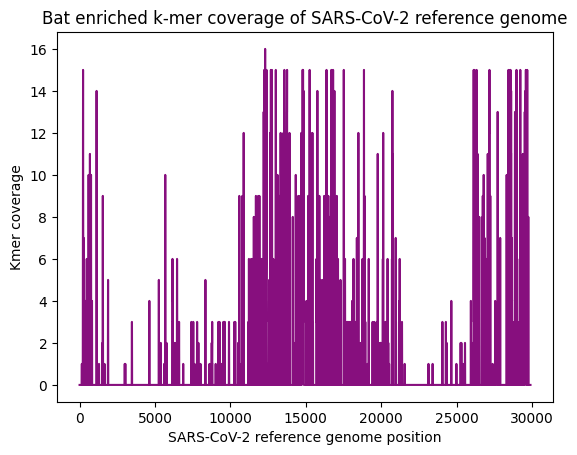

In [13]:
fig, ax = plt.subplots()
ax.set_title("Bat enriched k-mer coverage of SARS-CoV-2 reference genome")
ax.set_xlabel("SARS-CoV-2 reference genome position")
ax.set_ylabel("Kmer coverage")
sns.lineplot(x=kmer_coverage.index, y=kmer_coverage["n_bat_enriched"], color="#870f7e")
plt.show()

# plt.savefig("../output/bat/enr_bat_kmer_ref_coverage.svg", dpi = 600, format = "svg")

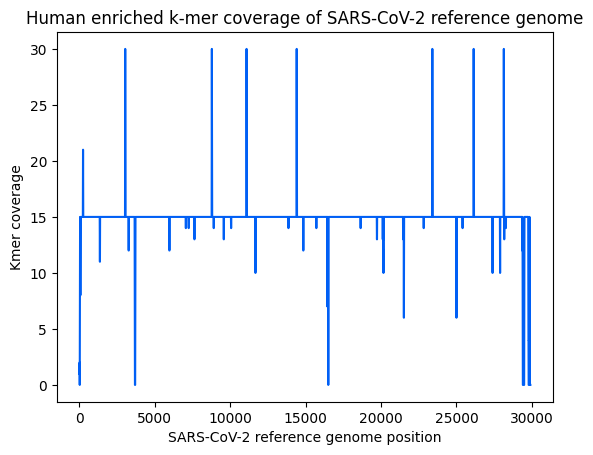

In [14]:
fig, ax = plt.subplots()
ax.set_title("Human enriched k-mer coverage of SARS-CoV-2 reference genome")
ax.set_xlabel("SARS-CoV-2 reference genome position")
ax.set_ylabel("Kmer coverage")
sns.lineplot(
    x=kmer_coverage.index, y=kmer_coverage["n_human_enriched"], color="#005ff5"
)
plt.show()

# plt.savefig("../output/bat/enr_human_kmer_ref_coverage.svg", dpi = 600, format = "svg")

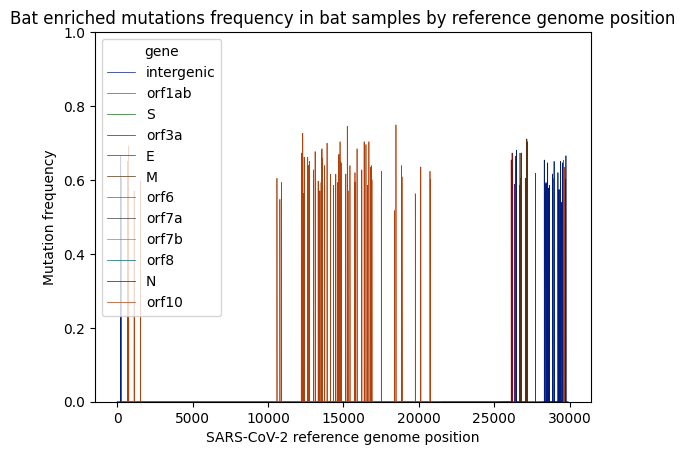

In [15]:
fig, ax = plt.subplots()
ax.set_title(
    "Bat enriched mutations frequency in bat samples by reference genome position"
)
ax.set_xlabel("SARS-CoV-2 reference genome position")
ax.set_ylabel("Mutation frequency")
ax.set_ylim(0, 1)
sns.lineplot(
    data=mutation_coverage,
    x=mutation_coverage.index,
    y="bat_mut_freq_in_bat",
    linewidth=0.5,
    hue="gene",
    palette="dark",
    drawstyle="steps",
)
plt.show()

# plt.savefig("../output/bat/enr_bat_mut_in_bat.svg", dpi = 600, format = "svg", bbox_inches='tight')

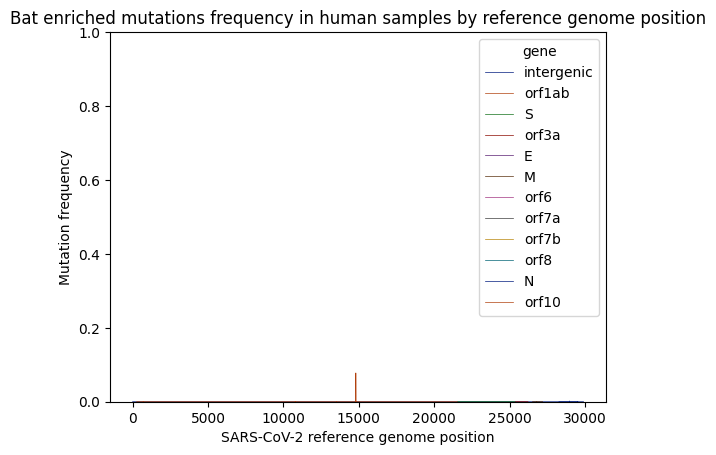

In [16]:
fig, ax = plt.subplots()
ax.set_title(
    "Bat enriched mutations frequency in human samples by reference genome position"
)
ax.set_xlabel("SARS-CoV-2 reference genome position")
ax.set_ylabel("Mutation frequency")
ax.set_ylim(0, 1)
sns.lineplot(
    data=mutation_coverage,
    x=mutation_coverage.index,
    y="bat_mut_freq_in_human",
    linewidth=0.5,
    hue="gene",
    palette="dark",
    drawstyle="steps",
)
plt.show()

# plt.savefig("../output/bat/enr_bat_mut_in_human.svg", dpi = 600, format = "svg", bbox_inches='tight')

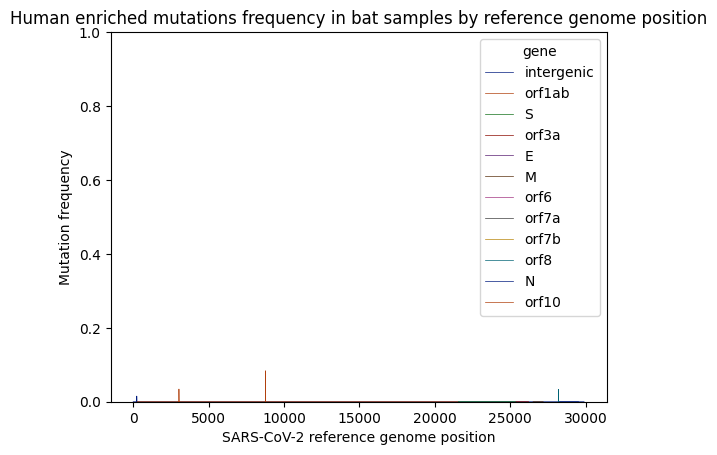

In [17]:
fig, ax = plt.subplots()
ax.set_title(
    "Human enriched mutations frequency in bat samples by reference genome position"
)
ax.set_xlabel("SARS-CoV-2 reference genome position")
ax.set_ylabel("Mutation frequency")
ax.set_ylim(0, 1)
sns.lineplot(
    data=mutation_coverage,
    x=mutation_coverage.index,
    y="human_mut_freq_in_bat",
    linewidth=0.5,
    hue="gene",
    palette="dark",
    drawstyle="steps",
)
plt.show()

# plt.savefig("../output/bat/enr_human_mut_in_bat.svg", dpi = 600, format = "svg", bbox_inches='tight')

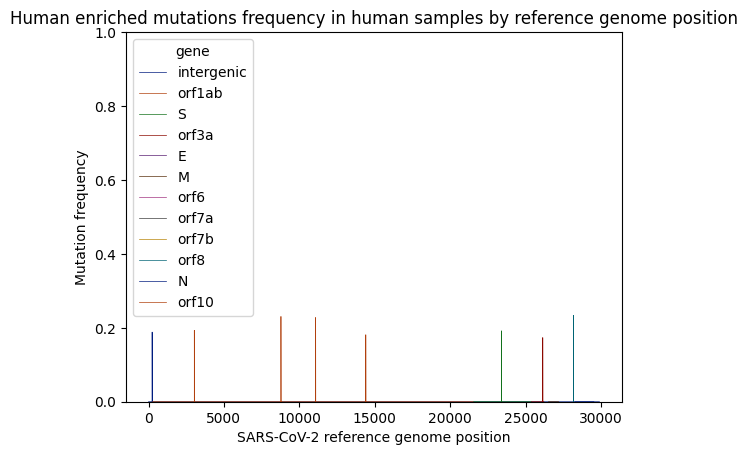

In [18]:
fig, ax = plt.subplots()
ax.set_title(
    "Human enriched mutations frequency in human samples by reference genome position"
)
ax.set_xlabel("SARS-CoV-2 reference genome position")
ax.set_ylabel("Mutation frequency")
ax.set_ylim(0, 1)
sns.lineplot(
    data=mutation_coverage,
    x=mutation_coverage.index,
    y="human_mut_freq_in_human",
    linewidth=0.5,
    hue="gene",
    palette="dark",
    drawstyle="steps",
)
plt.show()

# plt.savefig("../output/bat/enr_human_mut_in_human.svg", dpi = 600, format = "svg", bbox_inches='tight')